# DCT
**A. Read the mandril image at the input and divide it into blocks of different sizes (64, 16, 8).
In each blocked image, first apply the dct conversion to each block, then produce a mask as shown.
Filter values from each block. Then apply the inverse dct function to each block and reconstruct the image.**

**B. First, divide the image into 64-size blocks. Divide 10% of the blocks with the highest sharpness into size 16 blocks. Do this process one more step and divide 10% of the blocks with the highest sharpness into 8 size blocks. In each block, first apply the dct conversion to each block. Then, by generating a mask as shown, filter the values of each block. Then apply the inverse dct function to each block and reconstruct the image.
(The sharpness value can be calculated using the following code snippet)**

```cv2.Laplacian(image, cv2.CV_64F).var()```

**Report the execution time of these requested operations. Measure the quality of the images made compared to the original image using the PSNR method and report its execution time in a table. Report the relationship between image quality and block size and runtime. (The mask requested to apply to DCT coefficients holds a quarter of the coefficients.)**

### Part A

The following code snippet import required third-party libraries:
+ `cv2` for reading and utilizing image processing functions
+ `numpy` for calculating and considering images as numerical matrixes
+ `matplotlib.pyplot` for showing images in the output

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

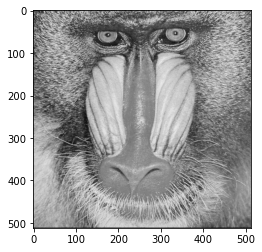

In [2]:
# Read mandril image
mandril = cv2.imread('../../images/mandril.tiff', 0)
plt.imshow(mandril, cmap = 'gray')
plt.show()

In [3]:
from numpy.lib.stride_tricks import as_strided as ast

In [4]:
# Read the array as a set of blocks
def block_view(A, block= (3, 3)):
    shape = (int(A.shape[0]/ block[0]), int(A.shape[1]/ block[1]))+ block
    strides = (block[0]* A.strides[0], block[1]* A.strides[1])+ A.strides
    return ast(A, shape = shape, strides= strides)

In [5]:
# Apply a function to each block of an image
def blkproc(I,block_size,fun):
    J = np.copy(I)
    BJ = block_view(J,block_size)
    for n in range(BJ.shape[0]):
        for m in range(BJ.shape[1]):
            BJ[n,m] = fun(BJ[n,m])
    return J

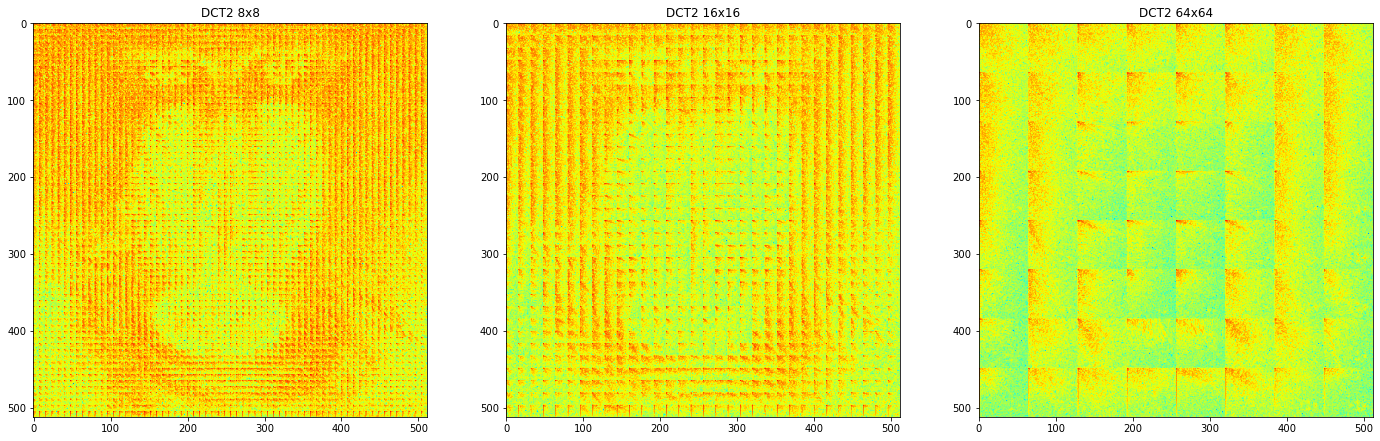

In [6]:
f, subplt = plt.subplots(1, 3, figsize=(24, 24))

# Apply DCT to each block of the image 
size = 8
blocked_img_8 = blkproc(np.array(mandril, dtype=np.float32), (size,size), cv2.dct)
subplt[0].imshow(np.log(0.0001 + np.abs(blocked_img_8)), cmap="jet")
subplt[0].set_title("DCT2 8x8")

size = 16
blocked_img_16 = blkproc(np.array(mandril, dtype=np.float32), (size,size), cv2.dct)
subplt[1].imshow(np.log(0.0001 + np.abs(blocked_img_16)), cmap="jet")
subplt[1].set_title("DCT2 16x16")

size = 64
blocked_img_64 = blkproc(np.array(mandril, dtype=np.float32), (size,size), cv2.dct)
subplt[2].imshow(np.log(0.0001 + np.abs(blocked_img_64)), cmap="jet")
subplt[2].set_title("DCT2 64x64")

plt.show()

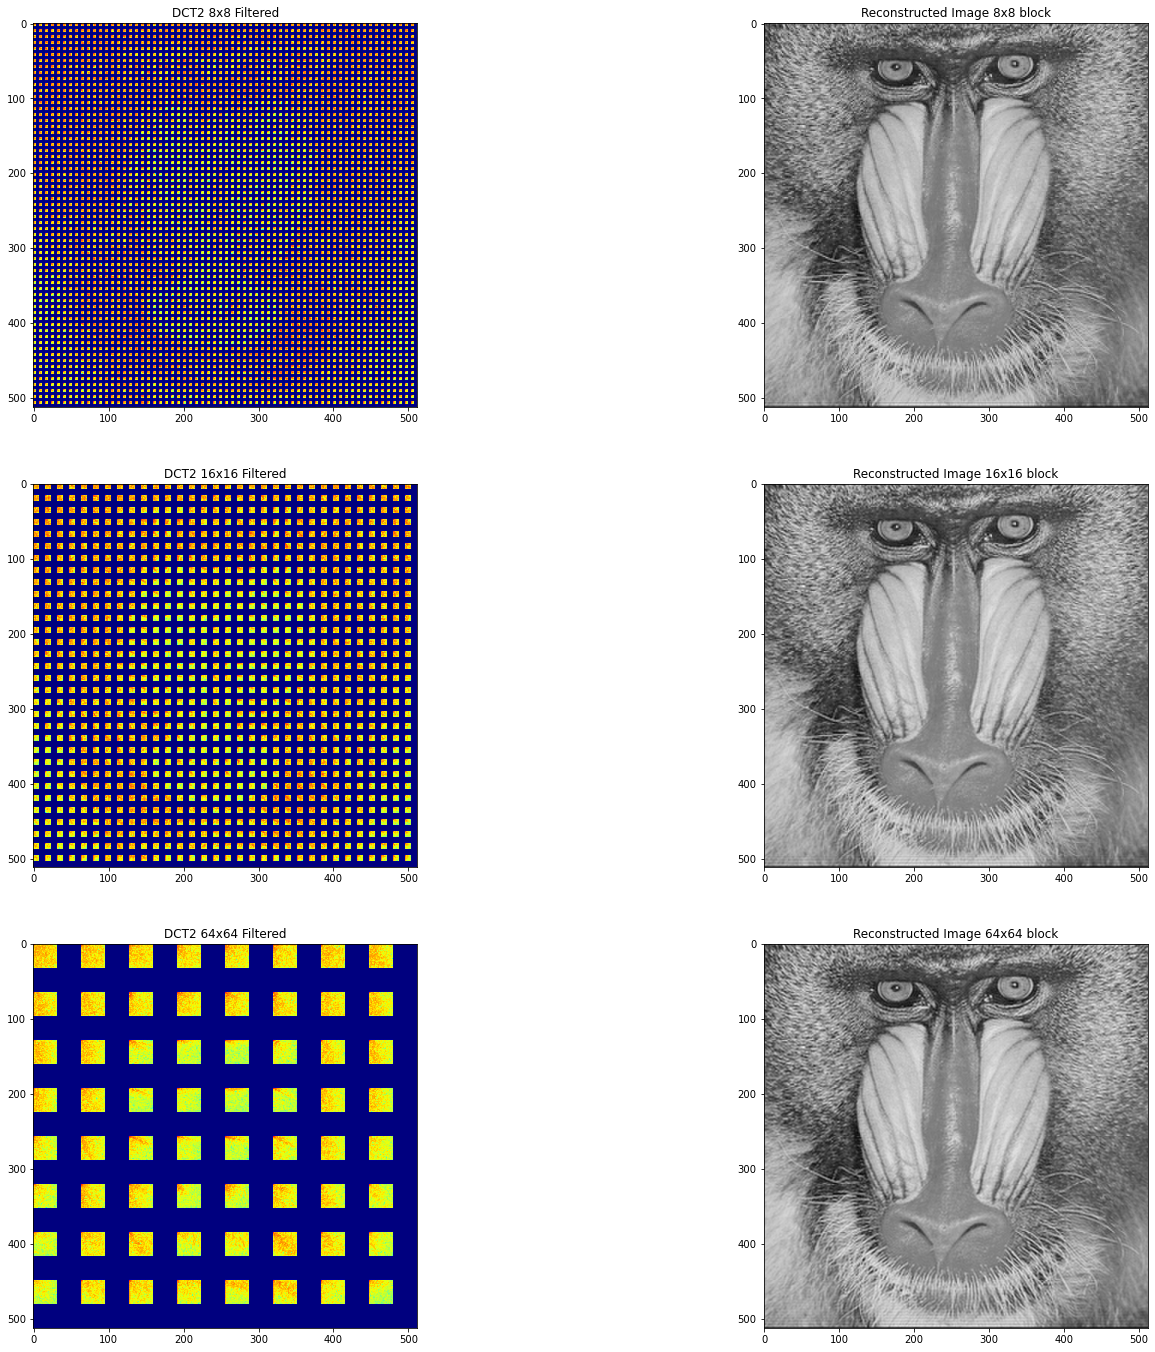

In [7]:
f, subplt = plt.subplots(3, 2, figsize=(24, 24))

# Create mask for keeping 1/4 of data
size = 8
mask = np.zeros((size,size))
mask[:size//2,:size//2] = 1
fun = lambda x:x*mask

# Apply the mask on the image
J_8 = blkproc(blocked_img_8,(size,size),fun)
subplt[0][0].imshow(np.log(0.0001 + np.abs(J_8)), cmap="jet")
subplt[0][0].set_title("DCT2 8x8 Filtered")

# Apply inverse DCT to reconstruct original image
reconstructed_8 = blkproc(J_8,(size,size),cv2.idct)
subplt[0][1].imshow(reconstructed_8, cmap="gray")
subplt[0][1].set_title("Reconstructed Image 8x8 block")

# Create mask for keeping 1/4 of data
size = 16
mask = np.zeros((size,size))
mask[:size//2,:size//2] = 1
fun = lambda x:x*mask

# Apply the mask on the image
J_16 = blkproc(blocked_img_16,(size,size),fun)
subplt[1][0].imshow(np.log(0.0001 + np.abs(J_16)), cmap="jet")
subplt[1][0].set_title("DCT2 16x16 Filtered")

# Apply inverse DCT to reconstruct original image
reconstructed_16 = blkproc(J_16,(size,size),cv2.idct)
subplt[1][1].imshow(reconstructed_16, cmap="gray")
subplt[1][1].set_title("Reconstructed Image 16x16 block")

# Create mask for keeping 1/4 of data
size = 64
mask = np.zeros((size,size))
mask[:size//2,:size//2] = 1
fun = lambda x:x*mask

# Apply the mask on the image
J_64 = blkproc(blocked_img_64,(size,size),fun)
subplt[2][0].imshow(np.log(0.0001 + np.abs(J_64)), cmap="jet")
subplt[2][0].set_title("DCT2 64x64 Filtered")

# Apply inverse DCT to reconstruct original image
reconstructed_64 = blkproc(J_64,(size,size),cv2.idct)
subplt[2][1].imshow(reconstructed_64, cmap="gray")
subplt[2][1].set_title("Reconstructed Image 64x64 block")

plt.show()

The mandril image has many parts with high frequency, so it is really hard to notice the difference between each version. Theoretically, applying the mask to a larger block size would erase more data, and the quality of the reconstructed version should be low, although in this image it is subtle.

### Part B

In [8]:
def calculate_MSE(image_1, image_2):
    """
    image_1, image_2: images which it should calculate their MSE
    return MSE value
    """
    # Checking for equality of the images' sizes
    if sorted(image_1.shape) != sorted(image_2.shape):
        # raising error for images with different sizes
        raise ValueError("Arguements must have same shape.")
    # Calculating MSE value based on its formula
    size = image_1.shape
    MSE_array = (image_1 - image_2) ** 2
    return MSE_array.sum() / (size[0] * size[1])

def calculate_PSNR(image_1, image_2):
    """
    image_1, image_2: images which it should calculate their PSNR
    return PSNR value
    """
    MSE = calculate_MSE(image_1, image_2)
    # Check for MSE value to be zero
    if MSE == 0:
        return float("inf")
    # Calculating PSNR value based on its formula 
    PSNR = 10 * np.log(255 ** 2 / MSE)
    return PSNR

In [9]:
# Divide a block of image into smaller blocks
def divide_img(BJ, size):
    # Create mask for keeping 1/4 data
    mask = np.zeros((size,size))
    mask[:size//2,:size//2] = 1
    
    # Apply DCT to the input image
    J_blocked = blkproc(np.array(BJ, dtype=np.float32), (size,size), cv2.dct)
    BJ = block_view(np.array(BJ, dtype=np.float32), (size,size))
    
    fun = lambda x:x*mask
    # Apply mask
    J = blkproc(J_blocked,(size,size),fun)

    # Apply inversed DCT
    reconstructed = blkproc(J,(size,size), cv2.idct)
    
    # Calculate sharpness indicator for each block
    sharpness = calculate_sharpness(BJ, J_blocked.shape, 16)
    
    # Sort and find blocks with large sharpness
    max_sharpness = np.copy(sharpness).reshape((1,16))
    max_sharpness = np.sort(max_sharpness)[0]
    
    # Select 10% of the sharpest blocks
    selected_sharpness = max_sharpness[-len(max_sharpness)//10:]
    
    # Split each sharp block into smaller block
    for i in range(len(BJ)):
        for j in range(len(BJ[i])):
            if sharpness[i][j] in selected_sharpness:
                size = 8
                BJ[i][j] = blkproc(np.array(BJ[i][j], dtype=np.float32), (size,size), cv2.dct)
                mask = np.zeros((size,size))
                mask[:size//2,:size//2] = 1
                fun = lambda x:x*mask
                BJ[i][j] = blkproc(np.array(BJ[i][j], dtype=np.float32), (size,size), fun)
                reconstructed[i*16:(i+1)*16, j*16:(j+1)*16] = blkproc(BJ[i][j],(size,size),cv2.idct)
                 
    return reconstructed

# Calculate sharpness indicator
def calculate_sharpness(BJ, J_size, size):
    sharpness = np.zeros((J_size[0]//size, J_size[1]//size))
    for i in range(len(BJ)):
        for j in range(len(BJ[i])):
            sharpness[i][j] = cv2.Laplacian(BJ[i][j], cv2.CV_32F).var()
            
    return sharpness

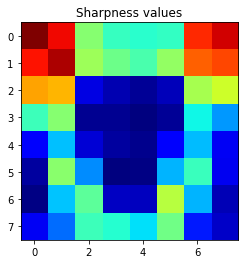

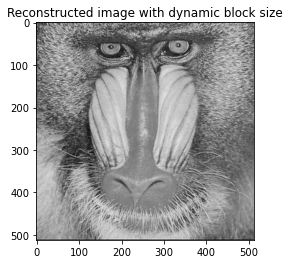

Wall time: 701 ms


In [13]:
%%time
# Apply DCT to the image
size = 64
J_64 = blkproc(np.array(mandril, dtype=np.float32), (size,size), cv2.dct)

BJ_64 = block_view(np.array(mandril, dtype=np.float32), (size,size))

# Calculate sharpness indicator for each block
sharpness = calculate_sharpness(BJ_64, J_64.shape, size)
        
# Show sharpness indicators
plt.imshow(sharpness, cmap = 'jet')
plt.title('Sharpness values')
plt.show()

# Create mask for keeping 1/4 data
mask = np.zeros((size,size))
mask[:size//2,:size//2] = 1
fun = lambda x:x*mask

# Apply mask to the image
J = blkproc(np.array(J_64, dtype=np.float32), (size,size), fun)

# Apply inversed DCT to the image
reconstructed_dynamic = blkproc(np.array(J, dtype=np.float32),(size,size), cv2.idct)

# Find and select the most sharp blocks
max_sharpness = np.copy(sharpness).reshape((1,64))
max_sharpness = np.sort(max_sharpness)[0]
selected_sharpness = max_sharpness[-len(max_sharpness)//10:]

# Split each sharp block with result of the smaller blocks reconstruction
for i in range(len(BJ_64)):
    for j in range(len(BJ_64[i])):
        if sharpness[i][j] in selected_sharpness:
            reconstructed_dynamic[i*64:(i+1)*64, j*64:(j+1)*64] = divide_img(BJ_64[i][j], 16)

# Show reconstructed image
plt.imshow(reconstructed_dynamic, cmap = 'gray')
plt.title('Reconstructed image with dynamic block size')
plt.show()

In the previous output we can see the elapsed time for spliting 10% of sharp blocks into smaller blocks and reconstrion of them.
Also we can see value of sharpness indicator for each block.

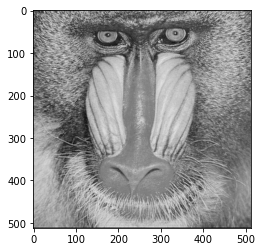

Wall time: 231 ms


In [11]:
%%time
# Apply DCT to the image
size = 64
blocked_img_64 = blkproc(np.array(mandril, dtype=np.float32), (size,size), cv2.dct)

# Create mask for keeping 1/4 of data
mask = np.zeros((size,size))
mask[:size//2,:size//2] = 1
fun = lambda x:x*mask

# Apply mask to the image
J_64 = blkproc(blocked_img_64,(size,size),fun)

# Apply inversed DCT to the image
reconstructed_64 = blkproc(J_64,(size,size),cv2.idct)

# Show reconstructed image
plt.imshow(reconstructed_64, cmap = 'gray')
plt.show()

In the previous output we can see the reconstructed image of 64x64 blocks, and its elapsed time.

In [15]:
print('PSNR of static block 64x64:', calculate_PSNR(reconstructed_64, mandril))
print('PSNR of dynamic blocks:', calculate_PSNR(reconstructed_dynamic, mandril))

PSNR of static block 64x64: 56.38615531146825
PSNR of dynamic blocks: 56.274141421572914


As we saw, splitting sharp blocks into smaller blocks will consume much more time (700ms compared to 200ms), also it does not provide any better performance using PSNR.
I believe that if the image has more low frequent parts splitting sharp parts into smaller blocks would provide better performance but in this high-frequency image static and dynamic block size give roughly equivalent results.